This jupyter notebook, among other things, requires rliable (open-source Python library for reliable evaluation).
To install it:
* pip3 install git+https://github.com/google-research/rliable
* pip3 install inflection

In [164]:
import os
import pandas as pd
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load all the optimized hyperparameter evaluations for decision-making algorithms

In [234]:
# path
path = './experiments/comparisons/'
# list of decision making algorithms
algorithms = ['gpmpc', 'ddpg', 'ppo', 'sac']
algorithms_name_maps = {'gpmpc': 'GP-MPC', 'ddpg': 'DDPG', 'ppo': 'PPO', 'sac': 'SAC'}
# list of strategies
strategies = ['s1', 's2', 's5', 's3', 's4']
strategy_name_maps = {'s1': 'naive_single_run',
                      's2': 'naive_multiple_runs', 
                      's3': 'multiple_runs_w/_CVaR', 
                      's4': 'AMRA_w/_CVaR', 
                      's5': 'AMRA_w/o_CVaR'}
# HPO runs
runs = ['run1', 'run2', 'run3']
# initialize dataframe
hpo_eval_df = pd.DataFrame()
hpo_effort_df = pd.DataFrame()
# load dataframe back from pickle file
for algorithm in algorithms:
    if algorithm == 'gpmpc':
        tmp_eval_df = pd.read_pickle(os.path.join(f'{algorithm}/', f'{algorithm}_hpo_eval.pkl'))
        tmp_effort_df = pd.read_pickle(os.path.join(f'{algorithm}/', f'{algorithm}_hpo_effort.pkl'))
        # add algorithm feature
        tmp_eval_df['algorithm'] = algorithm
        tmp_effort_df['algorithm'] = algorithm
        # concatenate temporary DataFrame with main DataFrame
        hpo_eval_df = pd.concat([hpo_eval_df, tmp_eval_df], ignore_index=True)
        hpo_effort_df = pd.concat([hpo_effort_df, tmp_effort_df], ignore_index=True)
    else:
        tmp_eval_df = pd.read_pickle(os.path.join(f'rl/{algorithm}/', f'{algorithm}_hpo_eval.pkl'))
        tmp_effort_df = pd.read_pickle(os.path.join(f'rl/{algorithm}/', f'{algorithm}_hpo_effort.pkl'))
        # add algorithm feature
        tmp_eval_df['algorithm'] = algorithm
        tmp_effort_df['algorithm'] = algorithm
        # concatenate temporary DataFrame with main DataFrame
        hpo_eval_df = pd.concat([hpo_eval_df, tmp_eval_df], ignore_index=True)
        hpo_effort_df = pd.concat([hpo_effort_df, tmp_effort_df], ignore_index=True)

Modify the plotting function in rliable library

In [168]:
# coding=utf-8
# Copyright 2021 The Rliable Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def _decorate_axis(ax, wrect=10, hrect=10, ticklabelsize='large'):
  """Helper function for decorating plots."""
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_linewidth(2)
  ax.spines['bottom'].set_linewidth(2)
  # Deal with ticks and the blank space at the origin
  ax.tick_params(length=0.1, width=0.1, labelsize=ticklabelsize)
  ax.spines['left'].set_position(('outward', hrect))
  ax.spines['bottom'].set_position(('outward', wrect))
  return ax

def plot_interval_estimates(point_estimates,
                            interval_estimates,
                            metric_names,
                            algorithms=None,
                            colors=None,
                            color_palette='colorblind',
                            max_ticks=4,
                            xticks=None,
                            subfigure_width=3.4,
                            row_height=0.37,
                            xlabel_y_coordinate=-0.1,
                            xlabel='Normalized Score',
                            **kwargs):
  """Plots various metrics with confidence intervals.

  Args:
    point_estimates: Dictionary mapping algorithm to a list or array of point
      estimates of the metrics to plot.
    interval_estimates: Dictionary mapping algorithms to interval estimates
      corresponding to the `point_estimates`. Typically, consists of stratified
      bootstrap CIs.
    metric_names: Names of the metrics corresponding to `point_estimates`.
    algorithms: List of methods used for plotting. If None, defaults to all the
      keys in `point_estimates`.
    colors: Maps each method to a color. If None, then this mapping is created
      based on `color_palette`.
    color_palette: `seaborn.color_palette` object for mapping each method to a
      color.
    max_ticks: Find nice tick locations with no more than `max_ticks`. Passed to
      `plt.MaxNLocator`.
    subfigure_width: Width of each subfigure.
    row_height: Height of each row in a subfigure.
    xlabel_y_coordinate: y-coordinate of the x-axis label.
    xlabel: Label for the x-axis.
    **kwargs: Arbitrary keyword arguments.

  Returns:
    fig: A matplotlib Figure.
    axes: `axes.Axes` or array of Axes.
  """

  if algorithms is None:
    algorithms = list(point_estimates.keys())
  num_metrics = len(point_estimates[algorithms[0]])
  figsize = (subfigure_width * num_metrics, row_height * len(algorithms))
  fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=figsize)
  if colors is None:
    color_palette = sns.color_palette(color_palette, n_colors=len(algorithms))
    colors = dict(zip(algorithms, color_palette))
  h = kwargs.pop('interval_height', 0.6)

  for idx, metric_name in enumerate(metric_names):
    for alg_idx, algorithm in enumerate(algorithms):
      ax = axes[idx] if num_metrics > 1 else axes
      # Plot interval estimates.
      lower, upper = interval_estimates[algorithm][:, idx]
      ax.barh(
          y=alg_idx,
          width=upper - lower,
          height=h,
          left=lower,
          color=colors[algorithm],
          alpha=0.75,
          label=algorithm)
      # Plot point estimates.
      ax.vlines(
          x=point_estimates[algorithm][idx],
          ymin=alg_idx - (7.5 * h / 16),
          ymax=alg_idx + (6 * h / 16),
          label=algorithm,
          color='k',
          alpha=0.5)
    ax.set_yticks(list(range(len(algorithms))))
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    if idx != 0:
      ax.set_yticks([])
    else:
      ax.set_yticklabels(algorithms, fontsize='x-large')
    ax.set_title(metric_name, fontsize='xx-large')
    ax.tick_params(axis='both', which='major')
    _decorate_axis(ax, ticklabelsize='xx-large', wrect=5)
    ax.spines['left'].set_visible(False)
    ax.grid(True, axis='x', alpha=0.25)
    if xticks is not None:
      ax.set_xticks(xticks)
  fig.text(0.4, xlabel_y_coordinate, xlabel, ha='center', fontsize='xx-large')
  plt.subplots_adjust(wspace=kwargs.pop('wspace', 0.11), left=0.0)
  return fig, axes

Store the stats in the dictionary

In [251]:
stats = {}

for algorithm in algorithms:
    for strategy in strategies:
        data_list = []
        for run in runs:
            tmp_array = hpo_eval_df.loc[hpo_eval_df['algorithm'] == algorithm].loc[hpo_eval_df['Category'] == strategy].loc[hpo_eval_df['Category_Run'] == f'{run}_{strategy}']['Reward'].to_numpy()
            tmp_array = tmp_array.reshape(-1, 1)
            # concatenate array vertically
            data_list.append(tmp_array)
        data_list = np.hstack(data_list)
        strategy_name = strategy_name_maps[strategy]
        algorithm_name = algorithms_name_maps[algorithm]
        stats[f'{algorithm_name} ({strategy_name})'] = data_list

In [240]:
# create stats list

stats_list = []
for algorithm in algorithms:
    stats_list.append({k: v for k, v in stats.items() if algorithms_name_maps[algorithm] in k})

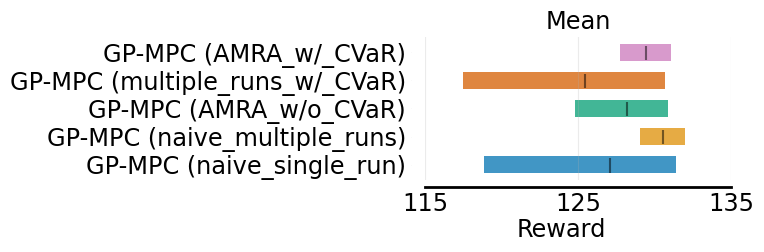

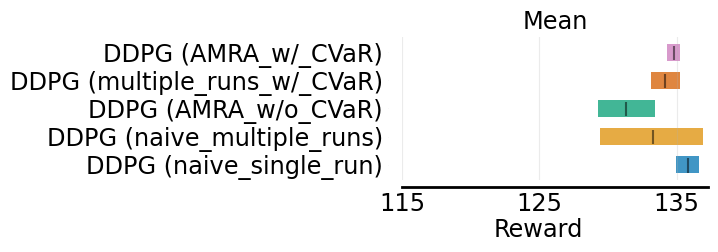

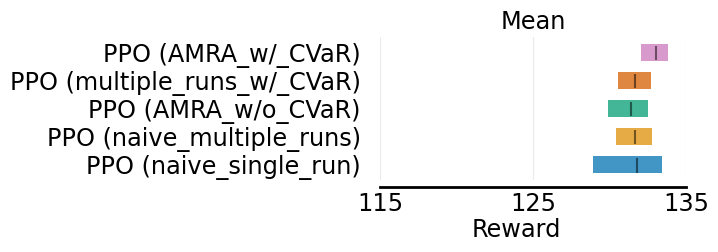

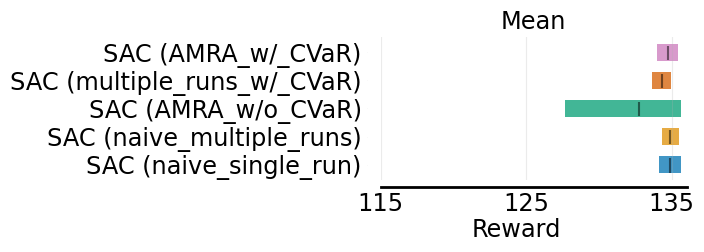

In [242]:
aggregate_func = lambda x: np.array([metrics.aggregate_mean(x)])
for stats in stats_list:
    aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(stats, 
                                                                                aggregate_func, 
                                                                                reps=50000, 
                                                                                task_bootstrap=True)
    fig, axes = plot_interval_estimates(aggregate_scores,
                                        aggregate_interval_estimates,
                                        metric_names=['Mean'],
                                        algorithms=list(stats.keys()), 
                                        xlabel='Reward',
                                        xticks=[115, 125, 135],
                                        xlabel_y_coordinate=-0.2)

Toward benchmarking for learning-based control and reinforcement learning

In [252]:
# create benchmark list
# gather gpmpc_s1, ddpg_s1,... in the dict

benchmark_list = []
for strategy in strategies:
    benchmark_list.append({k: v for k, v in stats.items() if strategy_name_maps[strategy] in k})

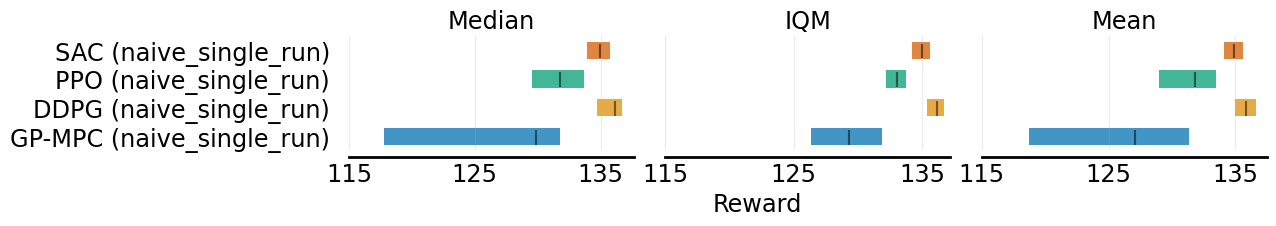

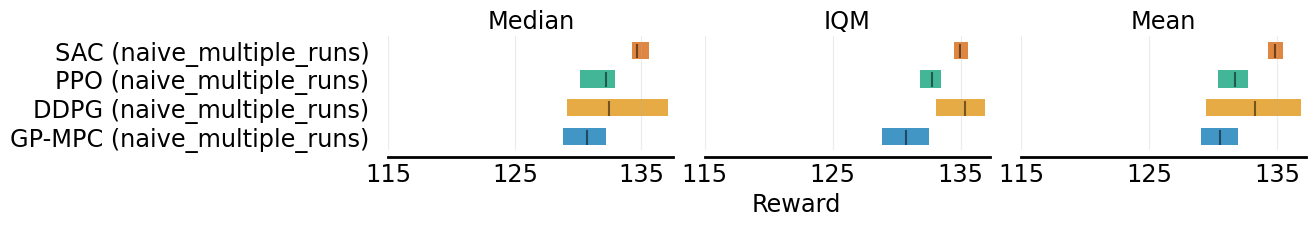

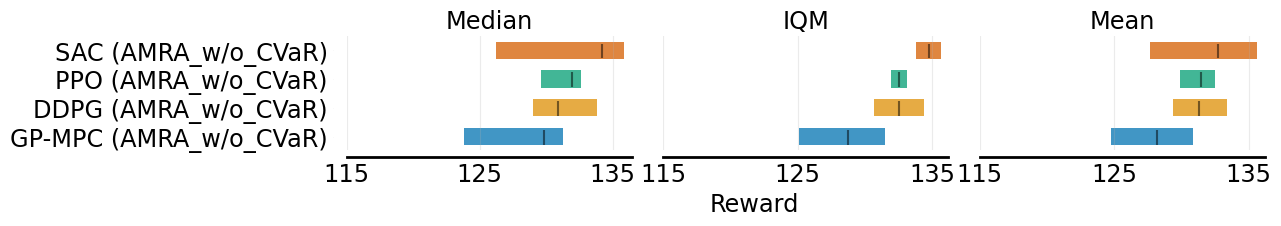

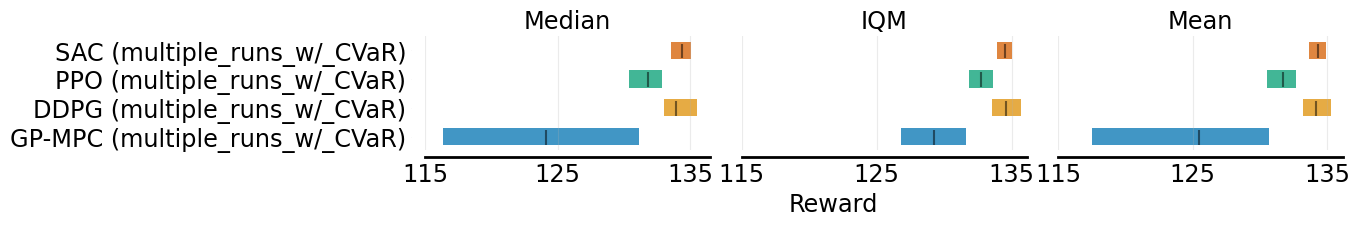

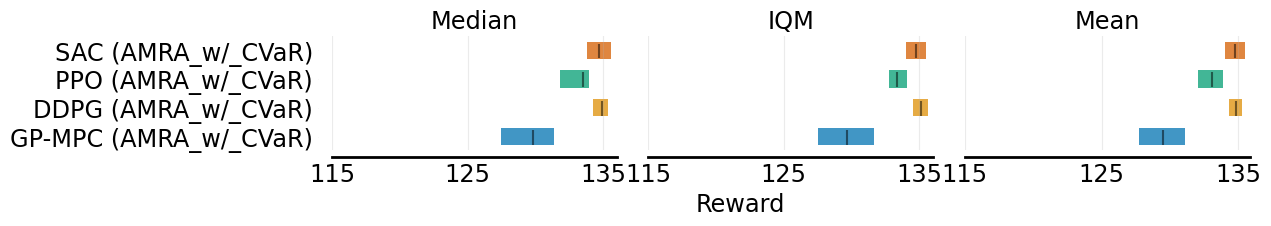

In [254]:
aggregate_func = lambda x: np.array([metrics.aggregate_median(x),
                                     metrics.aggregate_iqm(x),
                                     metrics.aggregate_mean(x)])
for stats in benchmark_list:
    aggregate_scores, aggregate_interval_estimates = rly.get_interval_estimates(stats, 
                                                                                aggregate_func, 
                                                                                reps=50000, 
                                                                                task_bootstrap=True)
    fig, axes = plot_interval_estimates(aggregate_scores,
                                        aggregate_interval_estimates,
                                        metric_names=['Median', 'IQM', 'Mean'],
                                        algorithms=list(stats.keys()), 
                                        xlabel='Reward',
                                        xticks=[115, 125, 135],
                                        xlabel_y_coordinate=-0.3)

Plot boxen plot

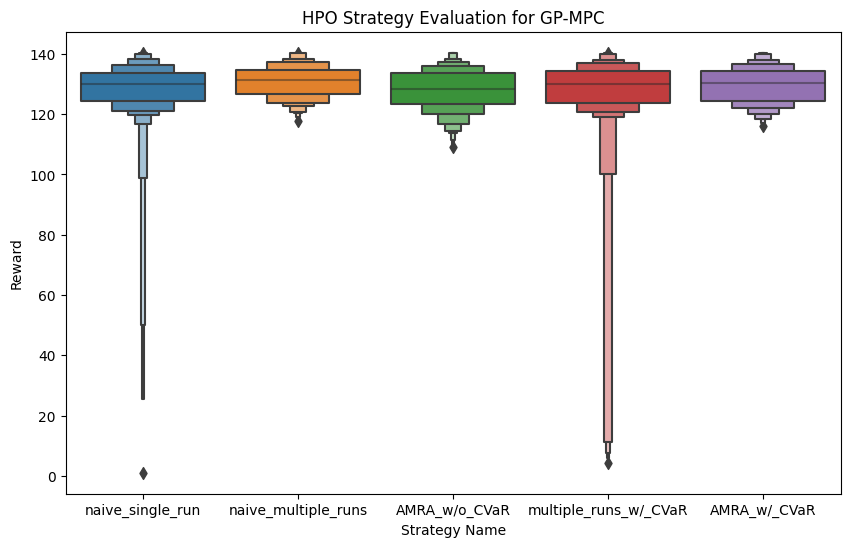

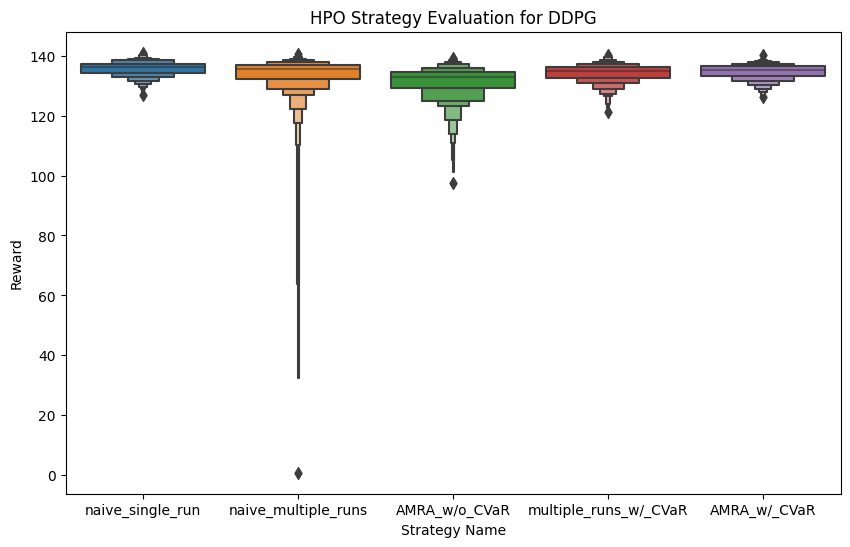

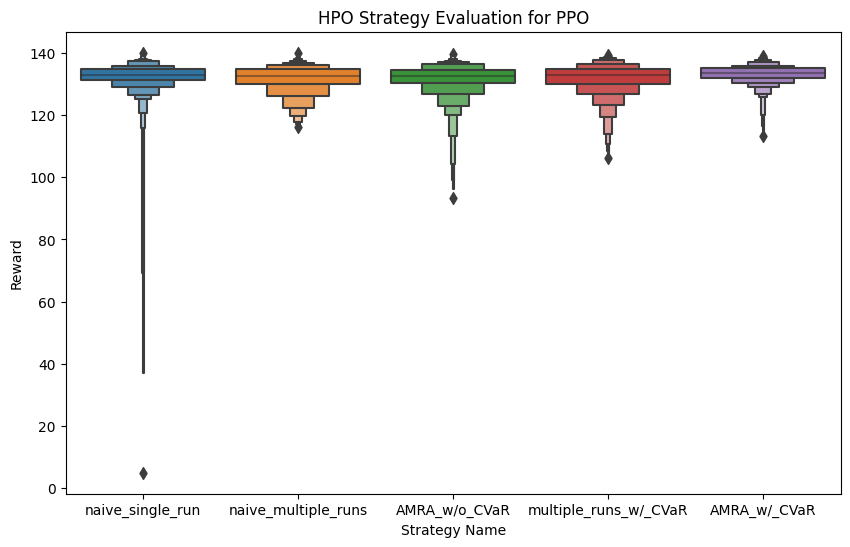

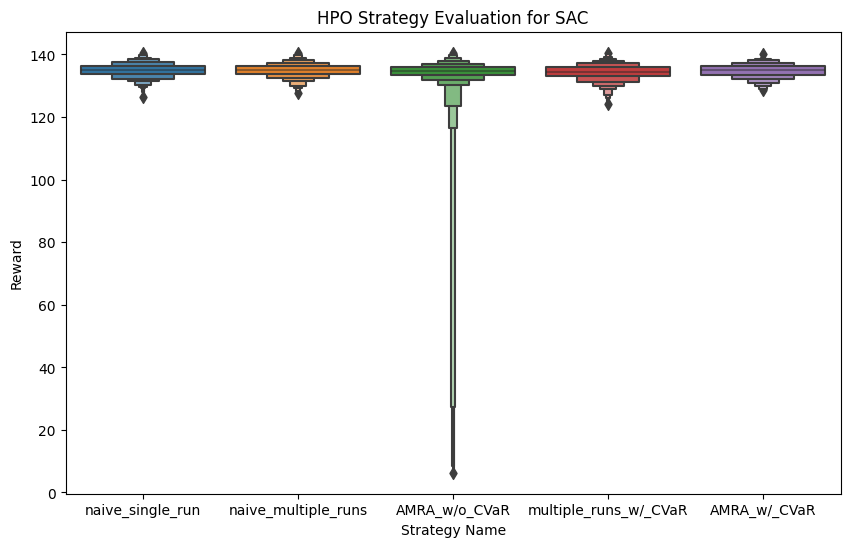

In [247]:
# plot boxen plot for each algorithm
for algorithm in algorithms:
    # add one feature called strategy name to the dataframe
    hpo_eval_df['strategy_name'] = hpo_eval_df['Category'].apply(lambda x: strategy_name_maps[x])
    # plot boxen plot
    plt.figure(figsize=(10, 6))
    # change the order of the boxen plot
    order=[strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']]
    sns.boxenplot(x='strategy_name', y='Reward', data=hpo_eval_df[hpo_eval_df['algorithm'] == algorithm], k_depth='proportion', order=order)
    plt.xlabel('Strategy Name')
    plt.ylabel('Reward')
    plt.title(f'HPO Strategy Evaluation for {algorithms_name_maps[algorithm]}')
    plt.show()
    plt.close()

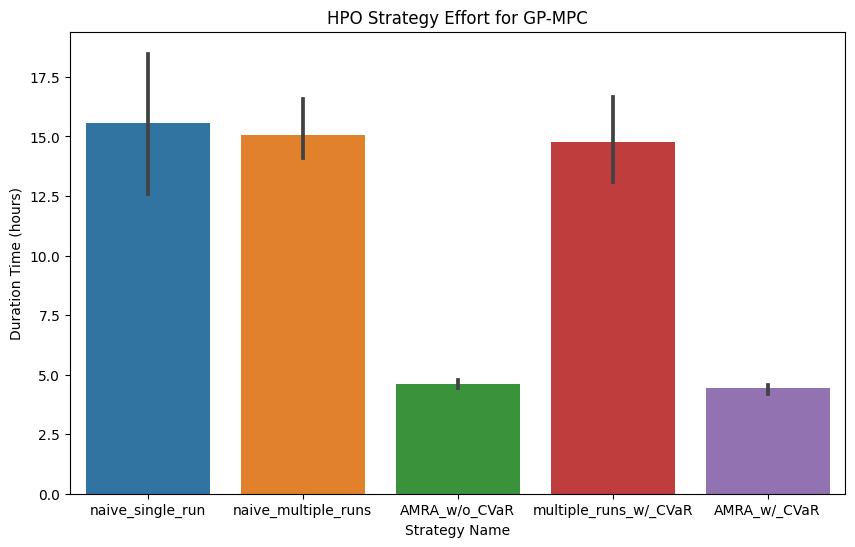

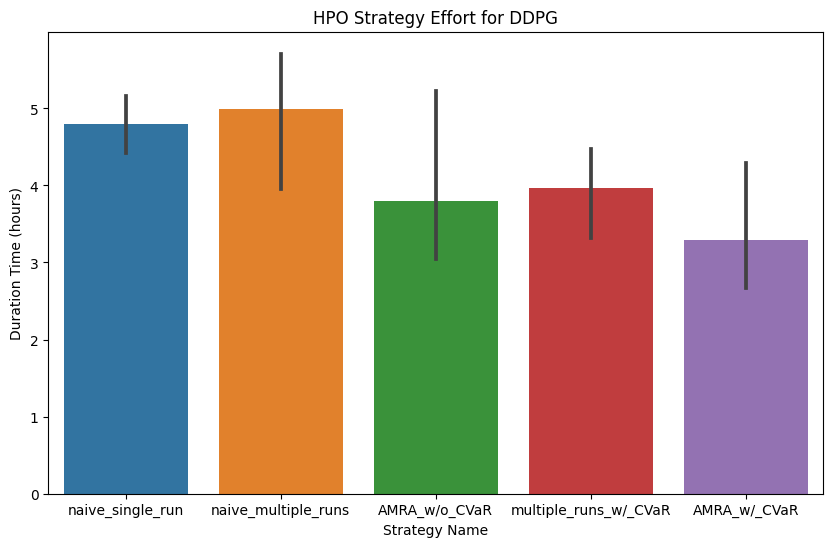

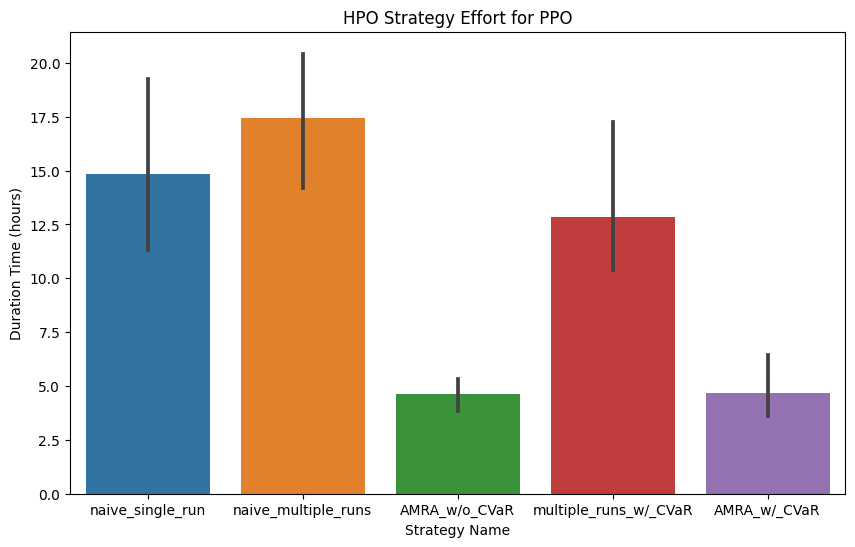

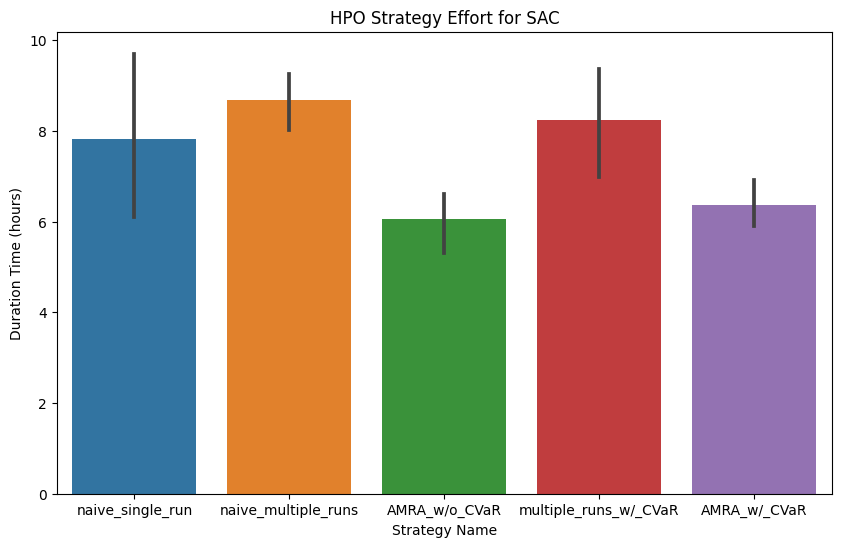

In [249]:
# plot boxen plot for each algorithm
for algorithm in algorithms:
    # add one feature called strategy name to the dataframe
    hpo_effort_df['strategy_name'] = hpo_effort_df['Category'].apply(lambda x: strategy_name_maps[x])
    # plot boxen plot
    plt.figure(figsize=(10, 6))
    # change the order of the boxen plot
    order=[strategy_name_maps['s1'], strategy_name_maps['s2'], strategy_name_maps['s5'], strategy_name_maps['s3'], strategy_name_maps['s4']]
    sns.barplot(x='strategy_name', y='Duration Time (hours)', data=hpo_effort_df[hpo_effort_df['algorithm'] == algorithm], order=order)
    plt.xlabel('Strategy Name')
    plt.ylabel('Duration Time (hours)')
    plt.title(f'HPO Strategy Effort for {algorithms_name_maps[algorithm]}')
    plt.show()
    plt.close()